In [1]:
import boto3
import os
from dotenv import load_dotenv
from pdf2image import convert_from_path
import pandas as pd
import pdb
from merge_dataframes import merge_dataframes
import argparse
import matplotlib.pyplot as plt
from get_column_borders import get_column_borders

# Load AWS credentials and region from .env file
load_dotenv()

aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
region_name = os.getenv('AWS_REGION')


In [2]:
# Initialize the Textract client
client = boto3.client('textract', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key, region_name=region_name)

# # Create an argument parser
# parser = argparse.ArgumentParser(description="Generate an output path based on the PDF file path")
# parser.add_argument("pdf_path", help="Path to the PDF file")
# args = parser.parse_args()

pdf_path = '../data/input/abacho_page_2.pdf'

# # Convert each page of the PDF to images and process with Textract
# images = convert_from_path(args.pdf_path)

images = convert_from_path(pdf_path)

# Define the subfolder name for CSV files
output_folder = 'data/output'

# Generate the CSV folder path by manipulating the PDF path
pdf_base_name = os.path.splitext(os.path.basename(pdf_path))[0]
csv_folder = os.path.join(output_folder, pdf_base_name)


In [3]:
image = images[0]
page_number = 1

# Define the CSV file path with the subfolder
csv_path = os.path.join(csv_folder, 'page_{}.csv'.format(page_number))

# Save the PNG image to a temporary file
image.save('page_{}.png'.format(page_number), 'PNG')

# Read the local image
with open('page_{}.png'.format(page_number), 'rb') as image_file:
    image_binary = image_file.read()

# Call Textract to analyze the image
response = client.detect_document_text(
    Document={
        'Bytes': image_binary
    }
)


In [4]:
# CELL 3

'''This section of code is used to find the header row with the numbers 1, 2, 3, 4, 5, 6, and 7 by
checking if there are 7 blocks in a row that meet those criteria.'''

# Define the expected text in eight consecutive lines
expected_text = ["1", "2", "3", "4", "5", "6", "7"]

# Initialize a counter to keep track of consecutive matches
consecutive_matches = 0

# Store information about the seven lines
lines = []

block_no = 0
last_sequence_block = -1

# Iterate through the Textract response blocks
for block in response['Blocks']:
    block_no += 1
    if block['BlockType'] == 'LINE':
        text = block['Text'].strip()
        if text == expected_text[consecutive_matches]:
            consecutive_matches += 1
            lines.append(block)
            if consecutive_matches == 7:
                last_sequence_block = block_no
                print("Seven consecutive lines with the expected text were found.")
                break
        else:
            consecutive_matches = 0  # Reset the counter if the text doesn't match
            lines = []

else:
    if consecutive_matches != 7:
        print("Seven consecutive lines with the expected text were not found.")

# Save the page object
page_object = response['Blocks'][0]  # Assuming the page object is the first block

Seven consecutive lines with the expected text were found.


In [5]:
# CELL 4

'''From the seven numbers in the header row, we can calculate the center x coordinate of 
each number's bounding box and this way create seven axes, one at the center of each column of the HRA.'''

vertical_lines = []

for i, line in enumerate(lines):
    # Extract the bounding box coordinates from the line object
    bbox = line['Geometry']['BoundingBox']
    left = bbox['Left']
    top = bbox['Top']
    width = bbox['Width']
    height = bbox['Height']

    # Calculate the coordinates of the bounding box (just as an fyi in case it's useful somewhere else)
    x1 = left
    x2 = left + width
    y1 = 1 - top
    y2 = 1 - top + height
    # create a center x coordinate of the bounding box
    center_x = x1 + width / 2

    vertical_lines.append(center_x)

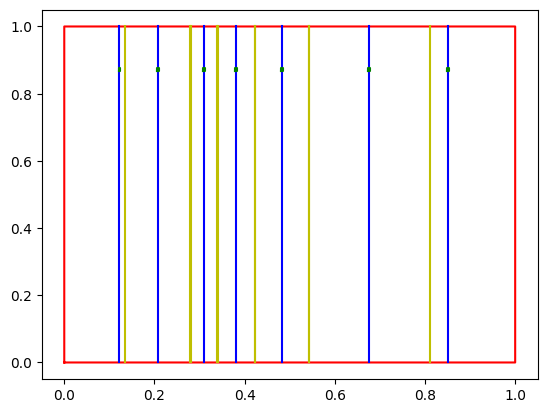

In [6]:
# PLOT

# plot the rectangle of the sheet

# Plot the four corner points of the page object to create a rectangle
page_polygon = page_object['Geometry']['Polygon']
page_x = [point['X'] for point in page_polygon]
page_y = [point['Y'] for point in page_polygon]
page_x.append(page_x[0])
page_y.append(page_y[0])
plt.plot(page_x, page_y, 'r-')  # Connect the corner points in red

for line in vertical_lines:
    # Create and plot lines that extend indefinitely in both directions
    plt.plot([line, line], [0, 1], 'b-')

for line in lines:
    # Extract the bounding box coordinates from the line object
    bbox = line['Geometry']['BoundingBox']
    left = bbox['Left']
    top = bbox['Top']
    width = bbox['Width']
    height = bbox['Height']

    # Calculate the coordinates of the bounding box
    x1 = left
    x2 = left + width
    y1 = 1 - top
    y2 = 1 - top + height

    # Plot the bounding box
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], 'g-')

for line in lines[1:6]:
    left, right = get_column_borders(line, image)
    plt.plot([left, left], [0, 1], 'y-')
    plt.plot([right, right], [0, 1], 'y-')

plt.show()

In [7]:
pdf_path = '../data/input/abacho_page_2.pdf'

images = convert_from_path(pdf_path)
image = images[0]

# get bounding box coordinates of line 1
bbox = lines[2]['Geometry']['BoundingBox']
bbox_left = bbox['Left']
bbox_top = bbox['Top']
bbox_width = bbox['Width']
bbox_height = bbox['Height']

# Convert coordinates to pixel coordinates
width, height = image.size
left = int(bbox_left * width)
top = int(bbox_top * height)
right = int((bbox_left + bbox_width) * width)
bottom = int((bbox_top + bbox_height) * height)

# Crop the tile
tile = image.crop((left, top, right, bottom))

# Save or display the cropped tile
tile.show()

In [8]:
# Crop the tile
tile = image.crop((left - 4, top, right -4, bottom))

# Save or display the cropped tile
tile.show()

In [11]:
# Convert initial coordinates to pixel coordinates
width, height = image.size
initial_left = int(bbox_left * width)
initial_top = int(bbox_top * height)
initial_right = int((bbox_left + bbox_width) * width)
initial_bottom = int((bbox_top + bbox_height) * height)

print(initial_top, initial_bottom)

# Define a darkness threshold (adjust as needed)
threshold = 100  # You can adjust this value

# Define the tile width and height
tile_width = 2  # Fixed width of 2 pixels
tile_height = initial_bottom - initial_top  # Height remains the same

# Initialize the left and right coordinates for checking the right side, with a bit of padding
left_coordinate_checking_right = initial_right + 3
right_coordinate_checking_right = initial_right + 3 + tile_width

# Initialize the left and right coordinates for checking the left side
left_coordinate_checking_left = initial_left - 3 - tile_width
right_coordinate_checking_left = initial_left - 3

# tile = image.crop((left, initial_top, right, initial_bottom))
# tile.show()

219 235


In [12]:
# checking the right side

while right_coordinate_checking_left < width:
    print("Evaluating tile at:", left_coordinate_checking_right, right_coordinate_checking_right)

    # Crop the tile
    tile = image.crop((left_coordinate_checking_right, initial_top, right_coordinate_checking_right, initial_bottom))

    # Convert the tile to grayscale
    gray_tile = tile.convert("L")

    # Convert the tile to a list of pixel values
    pixels = list(gray_tile.getdata())

    # Count the number of dark pixels
    dark_pixel_count = sum(1 for pixel in pixels if pixel < threshold)

    # Calculate the total number of pixels in the tile
    total_pixels = tile_width * tile_height

    # Check if at least half of the pixels are dark
    if dark_pixel_count >= 0.5 * total_pixels:
        break  # Half of the pixels are dark, exit the loop
    else:
        left_coordinate_checking_right += 1  # Move the tile one pixel to the right
        right_coordinate_checking_right += 1

# The 'left' variable now contains the leftmost position where half of the pixels are dark
print("Left position where half of the pixels are dark, checking towards the right:", left_coordinate_checking_right)

# checking the left side

while right_coordinate_checking_left < width:
    print("Evaluating tile at:", left_coordinate_checking_left, right_coordinate_checking_left)

    # Crop the tile
    tile = image.crop((left_coordinate_checking_left, initial_top, right_coordinate_checking_left, initial_bottom))

    # Convert the tile to grayscale
    gray_tile = tile.convert("L")

    # Convert the tile to a list of pixel values
    pixels = list(gray_tile.getdata())

    # Count the number of dark pixels
    dark_pixel_count = sum(1 for pixel in pixels if pixel < threshold)

    # Calculate the total number of pixels in the tile
    total_pixels = tile_width * tile_height

    # Check if at least half of the pixels are dark
    if dark_pixel_count >= 0.5 * total_pixels:
        break  # Half of the pixels are dark, exit the loop
    else:
        left_coordinate_checking_left -= 1  # Move the tile one pixel to the right
        right_coordinate_checking_left -= 1

# The 'right' variable now contains the rightmost position where half of the pixels are dark
print("Right position where half of the pixels are dark, checking towards the right:", right_coordinate_checking_right)

# The 'left' variable now contains the leftmost position where half of the pixels are dark
print("Left position where half of the pixels are dark, checking towards the left:", left_coordinate_checking_left)

Evaluating tile at: 731 733
Evaluating tile at: 732 734
Evaluating tile at: 733 735
Evaluating tile at: 734 736
Evaluating tile at: 735 737
Evaluating tile at: 736 738
Evaluating tile at: 737 739
Evaluating tile at: 738 740
Evaluating tile at: 739 741
Evaluating tile at: 740 742
Evaluating tile at: 741 743
Evaluating tile at: 742 744
Evaluating tile at: 743 745
Evaluating tile at: 744 746
Evaluating tile at: 745 747
Evaluating tile at: 746 748
Evaluating tile at: 747 749
Evaluating tile at: 748 750
Evaluating tile at: 749 751
Evaluating tile at: 750 752
Evaluating tile at: 751 753
Evaluating tile at: 752 754
Evaluating tile at: 753 755
Evaluating tile at: 754 756
Evaluating tile at: 755 757
Evaluating tile at: 756 758
Evaluating tile at: 757 759
Evaluating tile at: 758 760
Evaluating tile at: 759 761
Evaluating tile at: 760 762
Evaluating tile at: 761 763
Evaluating tile at: 762 764
Evaluating tile at: 763 765
Evaluating tile at: 764 766
Evaluating tile at: 765 767
Evaluating tile at: 

In [13]:
right_tile = image.crop((left_coordinate_checking_right, initial_top - 100, right_coordinate_checking_right + 200, initial_bottom +100))
right_tile.show()

In [15]:
left_tile = image.crop((left_coordinate_checking_left - 200, initial_top - 100, right_coordinate_checking_left, initial_bottom +100))
left_tile.show()

In [ ]:
# sketch of decomposed version

for line in lines:
    